# Tarea 6. Distribución óptima de capital y selección de portafolios.

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/6e/Separation_theorem_of_MPT.svg/2000px-Separation_theorem_of_MPT.svg.png" width="400px" height="400px" />

**Resumen.**
> En esta tarea, tendrás la oportunidad de aplicar los conceptos y las herramientas que aprendimos en el módulo 3. Específicamente, utilizarás técnicas de optimización media-varianza para construir la frontera de mínima varianza, encontrar el mejor portafolio sobre la frontera mínima varianza, y finalmente, identificar la asignación óptima de capital para un inversionista dado su nivel de averisón al riesgo.

**Criterio de revisión.**
> Se te calificará de acuerdo a los resultados finales que reportes, basados en tu análisis.

**Antes de comenzar.**
> Por favor, copiar y pegar este archivo en otra ubicación. Antes de comenzar, nombrarlo *Tarea6_ApellidoNombre*, sin acentos y sin espacios; por ejemplo, en mi caso el archivo se llamaría *Tarea6_JimenezEsteban*. Resolver todos los puntos en dicho archivo y subir en este espacio.

## 1. Datos (10 puntos)

Considere los siguientes datos de bonos, índice de acciones, mercados desarrollados, mercados emergentes, fondos privados, activos reales y activos libres de riesgo:

In [1]:
# Importamos pandas y numpy
import pandas as pd
import numpy as np

In [22]:
# Resumen en base anual de rendimientos esperados y volatilidades
annual_ret_summ = pd.DataFrame(columns=['Bonos', 'Acciones', 'Desarrollado', 'Emergente', 'Privados', 'Real', 'Libre_riesgo'], index=['Media', 'Volatilidad'])
annual_ret_summ.loc['Media'] = np.array([0.0400, 0.1060, 0.0830, 0.1190, 0.1280, 0.0620, 0.0300])
annual_ret_summ.loc['Volatilidad'] = np.array([0.0680, 0.2240, 0.2210, 0.3000, 0.2310, 0.0680, None])

annual_ret_summ.round(4)

,Bonos,Acciones,Desarrollado,Emergente,Privados,Real,Libre_riesgo
Media,0.04,0.106,0.083,0.119,0.128,0.062,0.03
Volatilidad,0.068,0.224,0.221,0.3,0.231,0.068,None


In [23]:
# Matriz de correlación
corr = pd.DataFrame(data= np.array([[1.0000, 0.4000, 0.2500, 0.2000, 0.1500, 0.2000],
                                    [0.4000, 1.0000, 0.7000, 0.6000, 0.7000, 0.2000],
                                    [0.2500, 0.7000, 1.0000, 0.7500, 0.6000, 0.1000],
                                    [0.2000, 0.6000, 0.7500, 1.0000, 0.2500, 0.1500],
                                    [0.1500, 0.7000, 0.6000, 0.2500, 1.0000, 0.3000],
                                    [0.2000, 0.2000, 0.1000, 0.1500, 0.3000, 1.0000]]),
                    columns=annual_ret_summ.columns[:-1], index=annual_ret_summ.columns[:-1])
corr.round(4)

,Bonos,Acciones,Desarrollado,Emergente,Privados,Real
Bonos,1.00,0.4,0.25,0.20,0.15,0.20
Acciones,0.40,1.0,0.70,0.60,0.70,0.20
Desarrollado,0.25,0.7,1.00,0.75,0.60,0.10
Emergente,0.20,0.6,0.75,1.00,0.25,0.15
Privados,0.15,0.7,0.60,0.25,1.00,0.30
Real,0.20,0.2,0.10,0.15,0.30,1.00


1. Graficar en el espacio de rendimiento esperado contra volatilidad cada uno de los activos (10 puntos).

In [24]:
import matplotlib.pyplot as plt              

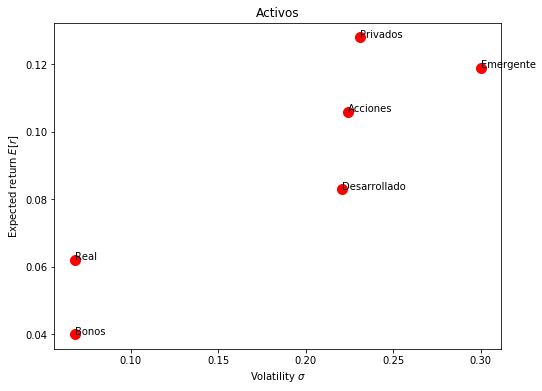

In [25]:
columns=['Bonos', 'Acciones', 'Desarrollado', 'Emergente', 'Privados', 'Real']
x=annual_ret_summ.loc['Volatilidad'].values
y=annual_ret_summ.loc['Media'].values
plt.figure(figsize=(8,6))
plt.plot(x,y,'ro',ms=10)
plt.xlabel('Volatility $\sigma$')
plt.ylabel('Expected return $E[r]$')
plt.title('Activos')
plt.text(x[0],y[0],columns[0])
plt.text(x[1],y[1],columns[1])
plt.text(x[2],y[2],columns[2])
plt.text(x[3],y[3],columns[3])
plt.text(x[4],y[4],columns[4])
plt.text(x[5],y[5],columns[5])
plt.show()

## 2. Hallando portafolios sobre la frontera de mínima varianza (35 puntos)

Usando los datos del punto anterior:

1. Halle los pesos del portafolio de mínima varianza considerando todos los activos riesgosos. También reportar claramente el rendimiento esperado, volatilidad y cociente de Sharpe para dicho portafolio (15 puntos).
2. Halle los pesos del portafolio EMV considerando todos los activos riesgosos. También reportar claramente el rendimiento esperado, volatilidad y cociente de Sharpe para dicho portafolio (15 puntos).
3. Halle la covarianza y la correlación entre los dos portafolios hallados (5 puntos)

In [26]:
rf=annual_ret_summ['Libre_riesgo']['Media']
annual_ret_summ=annual_ret_summ.drop('Libre_riesgo',1)

In [27]:
# Importamos scipy
from scipy.optimize import minimize
## Construcción de parámetros
# 1. Sigma: matriz de varianza-covarianza
D=np.diag(annual_ret_summ.loc['Volatilidad'])
Sigma = D.dot(corr).dot(D)
# 2. Eind: rendimientos esperados activos individuales
Eind = np.array(annual_ret_summ.loc['Media'])
# Función objetivo
def varianza(w, Sigma):
    return w.dot(Sigma).dot(w)
# Dato inicial
w0 = np.ones((6,))/6
# Cotas de las variables
bnds = ((0,1),)*6
# Restricciones
cons = ({'type': 'eq', 'fun': lambda w: np.sum(w)-1},)
# Portafolio de mínima varianza
#min_var = opt.minimize(varianza, w0, args=(Sigma,), bounds=bnds, constraints=cons)
min_var = minimize(varianza, w0, args=(Sigma,),bounds=bnds ,constraints=cons)
# Pesos, rendimiento y riesgo del portafolio de mínima varianza
w_minvar = min_var.x
E_minvar = Eind.dot(w_minvar)
s_minvar = np.sqrt(varianza(w_minvar,Sigma))
info = pd.DataFrame(columns=['Portafolio min var'], index=['Media', 'Volatilidad','SR'])
info.loc['Media'] = E_minvar
info.loc['Volatilidad'] = s_minvar
info.loc['SR']=(E_minvar-rf)/s_minvar
print(info)
pesos = pd.DataFrame(columns=['Bonos', 'Acciones', 'Desarrollado', 'Emergente', 'Privados', 'Real'], index=['Peso'])
pesos.loc['Peso'] = w_minvar.round(5)
pesos

            Portafolio min var
Media                0.0511112
Volatilidad          0.0526736
SR                    0.400793


,Bonos,Acciones,Desarrollado,Emergente,Privados,Real
Peso,0.49515,0,0.00021,0,0,0.50464


In [28]:
# Función objetivo
def sharpe_r(w, Eind, Sigma, rf):
    erp=Eind.dot(w)
    varp=w.dot(Sigma).dot(w)
    return -(erp-rf)/np.sqrt(varp)
# Portafolio EMV
EMV = minimize(sharpe_r, w0, args=(Eind, Sigma, rf), bounds=bnds, constraints=cons)
w_EMV = EMV.x
E_EMV = Eind.dot(w_EMV)
s_EMV = np.sqrt(w_EMV.dot(Sigma).dot(w_EMV))
w_EMV,E_EMV, s_EMV
info = pd.DataFrame(columns=['Portafolio EMV'], index=['Media', 'Volatilidad','SR'])
info.loc['Media'] = E_EMV
info.loc['Volatilidad'] = s_EMV
info.loc['SR']=(E_EMV-rf)/s_EMV
print(info)
pesos = pd.DataFrame(columns=['Bonos', 'Acciones', 'Desarrollado', 'Emergente', 'Privados', 'Real'], index=['Peso'])
pesos.loc['Peso'] = w_EMV.round(5)
pesos

            Portafolio EMV
Media            0.0776161
Volatilidad      0.0819274
SR                0.581199


,Bonos,Acciones,Desarrollado,Emergente,Privados,Real
Peso,0,0,0,0.08192,0.16586,0.75222


In [16]:
# Covarianza entre los portafolios
cov_port = w_minvar.dot(Sigma).dot(w_EMV)
cov_port

0.0029818190366882494

In [17]:
# Correlación entre los portafolios
corr_port = cov_port/(s_EMV*s_minvar)
corr_port

0.6909707716261657

## 3. Frontera de mínima varianza y LAC (30 puntos)

Con los portafolios que se encontraron en el punto anterior (de mínima varianza y EMV):

1. Construya la frontera de mínima varianza calculando el rendimiento esperado y volatilidad para varias combinaciones de los anteriores portafolios. Reportar dichas combinaciones en un DataFrame incluyendo pesos, rendimiento, volatilidad y cociente de Sharpe (15 puntos).
2. También construya la línea de asignación de capital entre el activo libre de riesgo y el portafolio EMV. Reportar las combinaciones de estos activos en un DataFrame incluyendo pesos, rendimiento, volatilidad y cociente de Sharpe (15 puntos).

In [29]:
# Vector de w
n=1201
w=np.linspace(-4,8,n)

fron_minvar = pd.DataFrame(columns=['wEMV', '1-wEMV', 'Ret', 'Vol', 'SR'])
fron_minvar['wEMV'] = w
fron_minvar['1-wEMV'] = 1-w
fron_minvar['Ret'] = w*E_EMV+(1-w)*E_minvar
fron_minvar['Vol'] = np.sqrt((w*s_EMV)**2+((1-w)*s_minvar)**2+2*w*(1-w)*cov_port)
fron_minvar['SR'] = (fron_minvar['Ret']-rf)/fron_minvar['Vol']
fron_minvar.round(4)

,wEMV,1-wEMV,Ret,Vol,SR
0,-4.00,5.00,-0.0549,0.2398,-0.3541
1,-3.99,4.99,-0.0546,0.2392,-0.3539
2,-3.98,4.98,-0.0544,0.2386,-0.3536
3,-3.97,4.97,-0.0541,0.2380,-0.3534
4,-3.96,4.96,-0.0538,0.2374,-0.3531
5,-3.95,4.95,-0.0536,0.2369,-0.3529
6,-3.94,4.94,-0.0533,0.2363,-0.3526
7,-3.93,4.93,-0.0531,0.2357,-0.3524
8,-3.92,4.92,-0.0528,0.2351,-0.3521
9,-3.91,4.91,-0.0525,0.2345,-0.3518


In [30]:
LAC=pd.DataFrame(index=np.arange(n),columns=['wp','wrf','E[r]','vol','SR'])
LAC['wp']=w
LAC['wrf']=1-w
LAC['E[r]']=w*E_EMV+(1-w)*rf
LAC['vol']=w*s_EMV
LAC['SR']=(LAC['E[r]']-rf)/LAC['vol']
LAC

,wp,wrf,E[r],vol,SR
0,-4.00,5.00,-0.160464,-0.327709,0.581199
1,-3.99,4.99,-0.159988,-0.326890,0.581199
2,-3.98,4.98,-0.159512,-0.326071,0.581199
3,-3.97,4.97,-0.159036,-0.325252,0.581199
4,-3.96,4.96,-0.158560,-0.324432,0.581199
5,-3.95,4.95,-0.158083,-0.323613,0.581199
6,-3.94,4.94,-0.157607,-0.322794,0.581199
7,-3.93,4.93,-0.157131,-0.321975,0.581199
8,-3.92,4.92,-0.156655,-0.321155,0.581199
9,-3.91,4.91,-0.156179,-0.320336,0.581199


## 4. Gráficos y conclusiones (25 puntos)

1. Usando todos los datos obtenidos, grafique:
 - los activos individuales,
 - portafolio de mínima varianza,
 - portafolio eficiente en media-varianza (EMV),
 - frontera de mínima varianza, y
 - línea de asignación de capital,
en el espacio de rendimiento (eje $y$) vs. volatilidad (eje $x$). Asegúrese de etiquetar todo y poner distintos colores para diferenciar los distintos elementos en su gráfico (15 puntos).
2. Suponga que usted está aconsejando a un cliente cuyo coeficiente de aversión al riesgo resultó ser 4. ¿Qué asignación de capital le sugeriría?, ¿qué significa su resultado?(10 puntos)

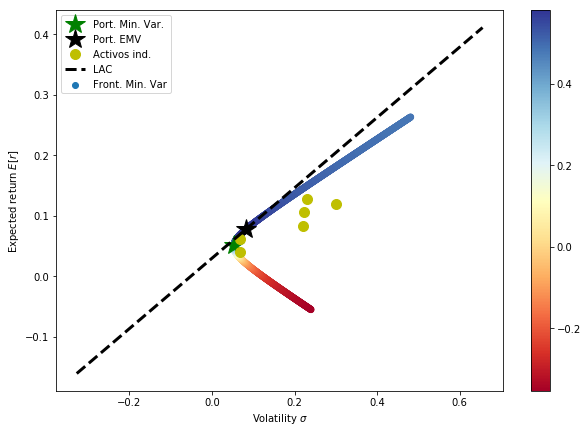

In [31]:
plt.figure(figsize=(10,7))
plt.plot(s_minvar, E_minvar, '*g', ms=20, label = 'Port. Min. Var.')
plt.plot(s_EMV, E_EMV, '*k', ms=20, label = 'Port. EMV')
plt.plot(annual_ret_summ.loc['Volatilidad'], Eind, 'oy', ms=10, label = 'Activos ind.')
plt.scatter(fron_minvar['Vol'], fron_minvar['Ret'], c=fron_minvar['SR'], cmap='RdYlBu', label = 'Front. Min. Var')
plt.plot(LAC['vol'],LAC['E[r]'],'k--',lw=3,label='LAC')
plt.xlabel('Volatility $\sigma$')
plt.ylabel('Expected return $E[r]$')
plt.legend(loc='best')

plt.colorbar()
plt.show()

In [32]:
(E_EMV-rf)/(4*(s_EMV**2))

1.7735181353168143

Al utilizar la formula que involucra el coeficiente de aversión, se obtiene w*=1.77, es decir, -.77 en el activo libre de riesgo y 1.77 en el portafolio de activos riesgoso.

Al ser w* mayor a 1, significa que el cliente debe tomar una posición corta en el activo libre de riesgo (suponiendo que se puede hacer esto) y una posición larga, en este caso del 177%, en el mercado de activos, es decir, apalancamiento.

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>